In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import scipy
import ECoG
from sklearn.metrics import r2_score
import pywt

In [2]:
import time

In [3]:
import pandas as pd

In [4]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")

In [5]:
data = ECoG.ECoG(x,y,downsample = True)
filtered = data.bandpass_filter(lowcut=0.2,highcut=60,fs = 100,inplace=True) 
data.signal = np.abs(data.signal)

In [10]:
centers = np.array([[187,168],[190,126],[225,180],[229,141],[264,227],[264,193],[266,152],[282,215],[303,236],
              [303,198],[306,155],[325,221],[325,178],[323,136],[343,246],[349,205],[347,162],[340,120],[365,230],
             [365,185],[362,143],[386,212],[385,164],[380,122],[400,233],[405,190],[405,147],[420,214],[424,165],[424,125],
              [455,165],[460,125]],dtype = 'float')
sig = np.abs(x[0,1:])
centers[:,0] = (centers[:,0] - centers[:,0].mean())/centers[:,0].std()
centers[:,1] = (centers[:,1]  -centers[:,1].mean())/centers[:,1].std()

In [6]:
data.signal = np.abs(data.signal)

In [63]:
X = Apply_local_model(data)

In [65]:
def normal_features(signal,centers):#signal is 32x1, centers 32x2
    M = np.dot(centers.T,signal)/np.sum(signal)
    cov = np.cov(centers.T,aweights=signal)
    return np.array([M[0],M[1],cov[0,0],cov[0,1],cov[1,1]])

def Apply_local_model(ecog, kind="Normal"):
    if kind=="Normal":
        return np.array([normal_features(ecog.signal[i,:],ecog.centers) for i in range(ecog.signal.shape[0])])

def save_data_to_csv(X,motion,time, exp_name):#X is T x N_f
    signal_df =pd.DataFrame(X,index = time)
    motion_df = pd.DataFrame(motion, index = time, columns=['X','Y','Z'])
    signal_df.to_csv('Sig_'+ exp_name + '.csv')
    motion_df.to_csv('Motion_prepr'+ exp_name + '.csv')


In [66]:
data_lm = data
data_lm.signal = X

In [69]:
%%time
freq = np.linspace(1,14.5,10)
scalo_pw, motion_pw,time_pw = data_lm.scalo(1,freq,start = 0,end = 100000) # preprocess first 3000(30 sec) objects of 

Wall time: 6min 46s


(125838, 5)

In [70]:
X = scalo_pw.reshape((scalo_pw.shape[0],scalo_pw.shape[1]*scalo_pw.shape[2]*scalo_pw.shape[3])) # transform a tensor to a matrix

In [71]:
X = (X - X.mean())/X.std()
for i in range(3):
    motion_pw[:,i] = (motion_pw[:,i] - motion_pw[:,i].mean())/motion_pw[:,i].std()

(980, 5, 10, 12)

In [72]:
X_train = X[:70000,:]
Y_train = motion_pw[:70000,:]
Y_test = motion_pw[70000:,:]
X_test = X[70000:,:]

In [48]:
def make_plots(model,X_train,Y_train,X_test,Y_test):
    Y_pred = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    plt.figure(figsize = (19,6))
    plt.plot(time_pw[:70000],Y_pred[:,2],label = 'predicted')
    plt.plot(time_pw[:70000],Y_train[:,2],label = 'true')
    plt.title("prediction of train data")
    plt.xlabel('t,sec')
    plt.ylabel('coord')
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (15,6))
    plt.plot(time_pw[70000:],Y_pred_test[:,2],label = 'predicted')
    plt.plot(time_pw[70000:],Y_test[:,2],label = 'true')
    plt.xlabel('t,sec')
    plt.title("prediction of test data")
    plt.ylabel('coord')
    plt.legend()
    plt.show()
    
    print("Test score = ",[scipy.stats.pearsonr(Y_test[:,i],Y_pred_test[:,i])[0] for i in range(3)])
    print("Train score = ", [scipy.stats.pearsonr(Y_train[:,i],Y_pred[:,i])[0]  for i in range(3)])

In [41]:
model = PLSRegression(n_components = 0)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
Y_pred_test = model.predict(X_test)

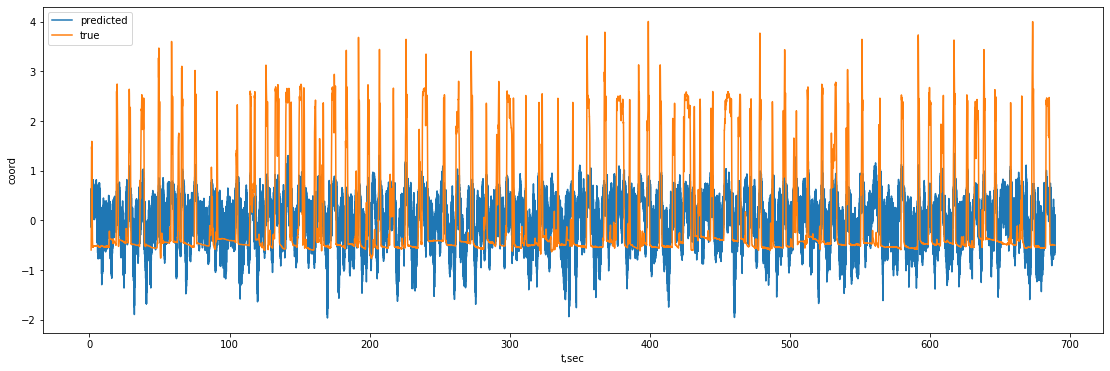

In [42]:
plt.figure(figsize = (19,6))
plt.plot(time_pw[:70000],Y_pred[:,2],label = 'predicted')
plt.plot(time_pw[:70000],Y_train[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

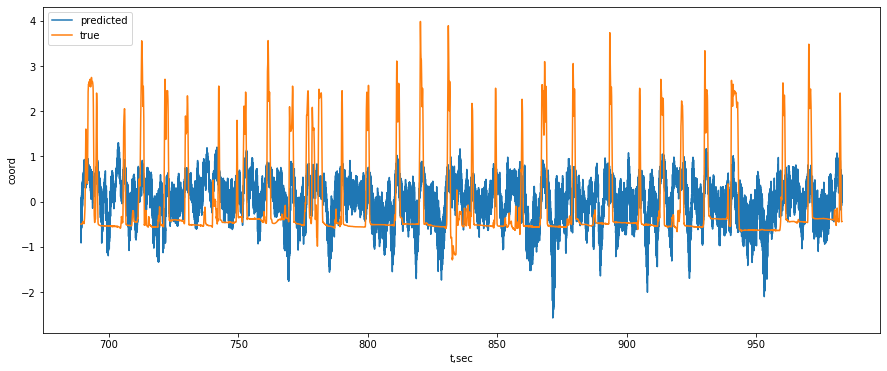

In [43]:
plt.figure(figsize = (15,6))
plt.plot(time_pw[70000:],Y_pred_test[:,2],label = 'predicted')
plt.plot(time_pw[70000:],Y_test[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

In [73]:
model = PLSRegression(n_components = 40)
model.fit(X_train,Y_train)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=True, tol=1e-06)

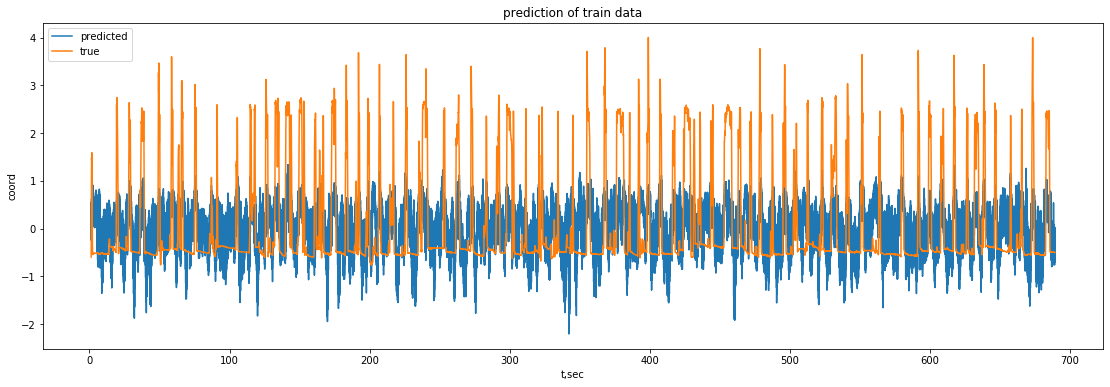

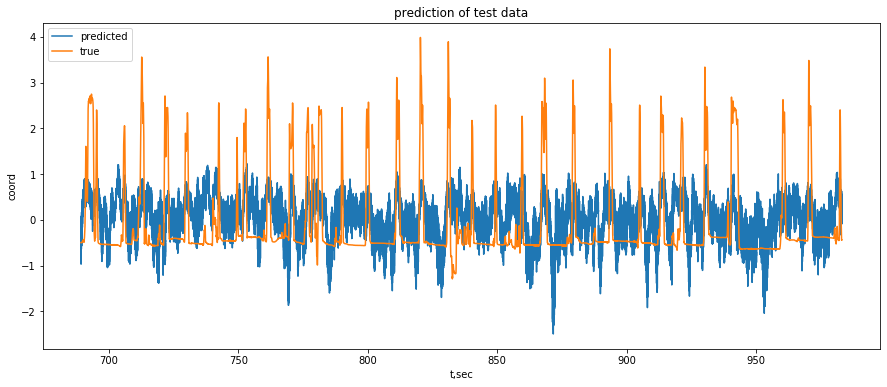

Test score =  [0.22139768664110487, 0.21793364570665727, 0.3493731694004317]
Train score =  [0.35826540729628503, 0.3902240372620362, 0.4401628209653891]


In [75]:
make_plots(model,X_train,Y_train,X_test,Y_test)

## Try normal distribution features

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def normal_features(signal,centers):#signal is 32x1, centers 32x2
    
    M = np.dot(centers.T,signal)/np.sum(signal)
    cov = np.cov(centers.T,aweights=signal)
    return np.array([M[0],M[1],cov[0,0],cov[0,1],cov[1,1]])

In [17]:
centers = np.array([[187,168],[190,126],[225,180],[229,141],[264,227],[264,193],[266,152],[282,215],[303,236],
              [303,198],[306,155],[325,221],[325,178],[323,136],[343,246],[349,205],[347,162],[340,120],[365,230],
             [365,185],[362,143],[386,212],[385,164],[380,122],[400,233],[405,190],[405,147],[420,214],[424,165],[424,125],
              [455,165],[460,125]],dtype = 'float')
sig = np.abs(x[0,1:])
centers[:,0] = (centers[:,0] - centers[:,0].mean())/centers[:,0].std()
centers[:,1] = (centers[:,1]  -centers[:,1].mean())/centers[:,1].std()

In [125]:
norm = normal_features(sig,centers)

In [126]:
def gaussian(args,x):
    res = np.empty((x.shape[0]))
    
    M = args[0:2]
    cov = args[2:5]
    Sigma = np.array([[cov[0],cov[1]],[cov[1],cov[2]]])
    B = 1#1/(2*np.pi*np.linalg.det(Sigma))
    for i in range(x.shape[0]):
        x0 = x[i,:]
        x0 = x0 - M
        res[i] = B * np.exp( -0.5 * np.dot(x0,np.dot(np.linalg.inv(Sigma),x0.T)))
       # print(res[i])
    return res


<IPython.core.display.Javascript object>


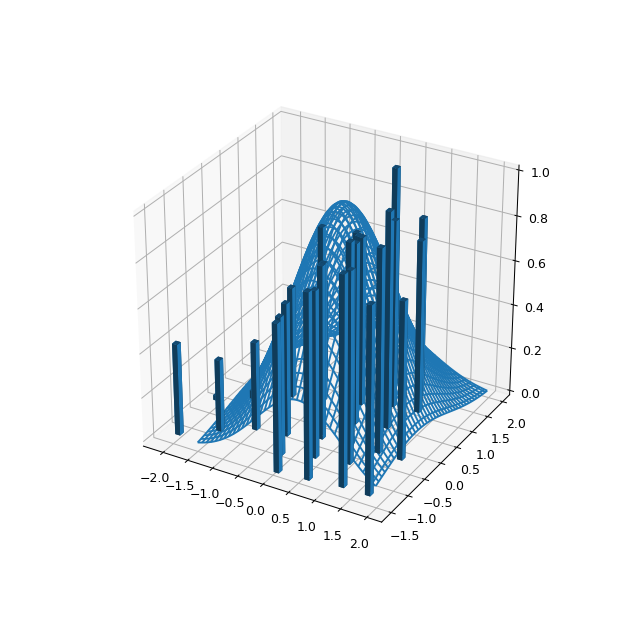

In [127]:
%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
Z = sig
ax.bar3d(centers[:,0], centers[:,1],np.zeros(32),0.1,0.1,Z/max(Z))


x, y = np.mgrid[-1.5:2.0:0.03, -1.5:2.0:0.03]
xy = np.column_stack([x.flat, y.flat])
z_gaus = gaussian(norm,xy)
z_gaus = z_gaus.reshape(x.shape)
ax.plot_wireframe(x,y,z_gaus)
#print(np.linalg.norm(Z/100 - gaussian(args,centers)))

Old transformation< normal features over spcalogram

In [18]:
scalo_pw = scalo_pw[:,:,:,1:-1]

In [19]:
%%time
Norm = np.empty((scalo_pw.shape[0],10,scalo_pw.shape[2],scalo_pw.shape[3]))
for i in range(scalo_pw.shape[0]):
    for j in range(scalo_pw.shape[2]):
        for k in range(1,scalo_pw.shape[3]-1):
            norm_der = (normal_features(scalo_pw[i,:,j,k+1],centers) - normal_features(scalo_pw[i,:,j,k-1],centers))/(0.2)
            Norm[i,:,j,k] = np.hstack((normal_features(scalo_pw[i,:,j,k],centers),norm_der))

Wall time: 24min 33s


In [20]:
X_norm = Norm.reshape((Norm.shape[0],Norm.shape[1]*Norm.shape[2]*Norm.shape[3]))